imagefolder

In [16]:
import torch
import torchvision
import matplotlib.pyplot

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [17]:
%matplotlib inline
trans = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [18]:
train_data = torchvision.datasets.ImageFolder(root='traindata', transform=trans)
data_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=8, shuffle=True, num_workers=2)

In [19]:
class CNN(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 6, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )

        self.fc1 = torch.nn.Linear(16*21*13, 120, bias=True)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(120, 2, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)

        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

    

In [20]:
net = CNN().to(device)
test_input = (torch.Tensor(3, 3, 96, 64)).to(device)
testout = net(test_input)

In [21]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-5)
loss_func = torch.nn.CrossEntropyLoss().to(device)

In [22]:
total_batch = len(data_loader)

epochs = 15
for epoch in range(epochs):
    avg_cost = 0.0
    for num, data in enumerate(data_loader):
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net(imgs)
        loss = loss_func(out, labels)
        loss.backward()
        optimizer.step()

        avg_cost += loss / total_batch
    print('[Epoch:{:2d}] cost = {}'.format(epoch + 1, avg_cost))
print('Learning Finished!')

[Epoch: 1] cost = 0.6971896290779114
[Epoch: 2] cost = 0.6958388090133667
[Epoch: 3] cost = 0.6886879205703735
[Epoch: 4] cost = 0.6852393746376038
[Epoch: 5] cost = 0.6839495301246643
[Epoch: 6] cost = 0.6832552552223206
[Epoch: 7] cost = 0.6794853806495667
[Epoch: 8] cost = 0.6792535781860352
[Epoch: 9] cost = 0.6772222518920898
[Epoch:10] cost = 0.6753728985786438
[Epoch:11] cost = 0.6723414659500122
[Epoch:12] cost = 0.6716600656509399
[Epoch:13] cost = 0.6671715974807739
[Epoch:14] cost = 0.6700775027275085
[Epoch:15] cost = 0.6707608103752136
Learning Finished!


In [23]:
torch.save(net.state_dict(), './model/model.pth')

In [24]:
new_net = CNN().to(device)

In [25]:
new_net.load_state_dict(torch.load('./model/model.pth'))

<All keys matched successfully>

In [26]:
test_data = torchvision.datasets.ImageFolder(root='testdata', transform=trans)
test_set = torch.utils.data.DataLoader(dataset = test_data, batch_size = 1)


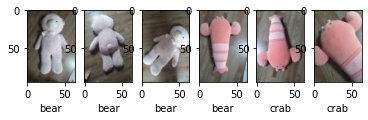

In [27]:
for num, data in enumerate(test_set):
    img, label = data
    tmp = img.view(3, 64, 96).transpose(0, 2)
    matplotlib.pyplot.subplot(1, 6, num + 1)
    matplotlib.pyplot.imshow(tmp)
    img = img.to(device)

    prediction = new_net(img).argmax(dim = 1)
    if prediction == 1:
        matplotlib.pyplot.xlabel('crab')
    else:
        matplotlib.pyplot.xlabel('bear')

    